In [148]:
import pandas as pd
import Levenshtein as lev
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import networkx as nx
import gravis as gv

# Note you will need to download muscle into the usr/bin and rename it simply as muscle
import biotite.sequence as seq
import biotite.application.muscle as muscle
import biotite.sequence.graphics as graphics

from scipy.stats import mode

import itertools

# Set 1

In [149]:
os.chdir('/home/jupyter') #/data')

In [150]:
pool1 = pd.read_csv("data/ILT4-pool1-10062022/filtered_contig_annotations.csv")
#pool1 = pd.read_csv("ILT4-pool1-10062022/airr_rearrangement.tsv", sep="\t")
#pool1_filtered_barcodes = pd.read_csv("ILT4-pool1-10062022/filtered_contig_annotations.csv", usecols=['barcode'])['barcode'].to_list()
#pool1 = pool1[pool1.cell_id.isin(pool1_filtered_barcodes)]
pool1['sample_num'] = "pool_1"

pool2 = pd.read_csv("data/ILT4-pool2-10062022/filtered_contig_annotations.csv")
#pool2 = pd.read_csv("ILT4-pool2-10062022/airr_rearrangement.tsv", sep="\t")
#pool2_filtered_barcodes = pd.read_csv("ILT4-pool2-10062022/filtered_contig_annotations.csv", usecols=['barcode'])['barcode'].to_list()
#pool2 = pool2[pool2.cell_id.isin(pool2_filtered_barcodes)]
pool2['sample_num'] = "pool_2"

config = pd.concat([pool1, pool2], axis=0).reset_index(drop=True)
config

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,sample_num
0,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_1,True,516,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,2552,11,clonotype1,clonotype1_consensus_2,1,pool_1
1,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_2,True,568,IGH,IGHV1-53,NaN,IGHJ4,IGHG1,...,CARYYKYDYYAMDFW,TGTGCAAGATACTATAAATACGACTACTATGCTATGGACTTCTGG,GQGTSVTVSS,GGTCAAGGAACCTCAGTCACCGTCTCCTCAG,718,1,clonotype1,clonotype1_consensus_1,1,pool_1
2,AAACCTGAGTGCCATT-1,True,AAACCTGAGTGCCATT-1_contig_1,True,481,IGK,IGKV6-32,NaN,IGKJ2,IGKC,...,CQQDYSSLTF,TGTCAGCAGGATTATAGCTCTCTCACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,154,14,clonotype321,clonotype321_consensus_1,1,pool_1
3,AAACCTGCAAGCTGAG-1,True,AAACCTGCAAGCTGAG-1_contig_1,True,514,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,508,5,clonotype9,clonotype9_consensus_1,1,pool_1
4,AAACCTGCACATTCGA-1,True,AAACCTGCACATTCGA-1_contig_1,True,522,IGK,IGKV1-117,NaN,IGKJ2,IGKC,...,CFQGSHVPYTF,TGCTTTCAAGGTTCACATGTTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,234,15,clonotype5,clonotype5_consensus_1,1,pool_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16779,TTTGTCATCACCCGAG-1,True,TTTGTCATCACCCGAG-1_contig_2,True,651,IGH,IGHV2-9,NaN,IGHJ2,IGHM,...,CARDLYDYYFDYW,TGTGCCAGAGATCTCTATGATTACTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,2758,15,clonotype1362,clonotype1362_consensus_1,1,pool_2
16780,TTTGTCATCACGATGT-1,True,TTTGTCATCACGATGT-1_contig_1,True,523,IGK,IGKV3-12,NaN,IGKJ1,IGKC,...,CQHSRELPRTF,TGTCAGCACAGTAGGGAGCTTCCTCGGACGTTC,GGGTKLEIK,GGTGGAGGCACCAAGCTGGAAATCAAAC,836,15,clonotype76,clonotype76_consensus_2,2,pool_2
16781,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_1,True,712,IGH,IGHV5-9,NaN,IGHJ2,IGHD,...,CARQGLYGKGRYFDYW,TGTGCAAGACAGGGACTATATGGTAAAGGGAGGTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,284,2,clonotype2381,clonotype2381_consensus_1,1,pool_2
16782,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_2,True,497,IGK,IGKV19-93,NaN,IGKJ2,IGKC,...,CLQYDNLYTF,TGTCTACAGTATGATAATCTGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,912,10,clonotype2381,clonotype2381_consensus_2,1,pool_2


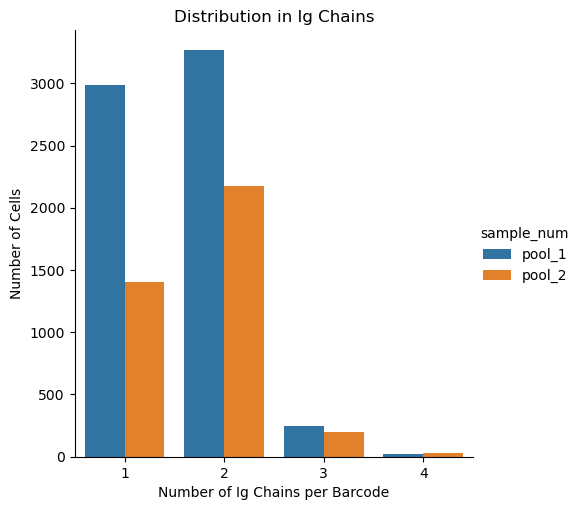

In [168]:
barcode_counts =  config.groupby(['sample_num', 'barcode']).count()[["is_cell"]].reset_index()

num_of_contigs_per_barcode = barcode_counts.groupby(['sample_num', "is_cell"]).count().reset_index()
num_of_contigs_per_barcode = num_of_contigs_per_barcode.rename(columns={"is_cell":"num_contigs", "barcode":"count"})

sns.catplot(data=num_of_contigs_per_barcode,
           x="num_contigs", y="count", hue="sample_num",
           kind="bar").set(title="Distribution in Ig Chains", 
                           xlabel="Number of Ig Chains per Barcode",
                           ylabel="Number of Cells");

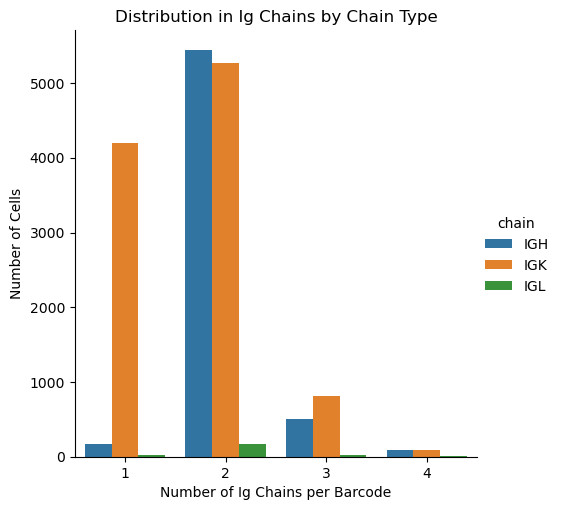

In [160]:
num_chains_vs_chain = barcode_counts.rename(columns={"is_cell": "num_chains"}).set_index(['sample_num', 'barcode']).join(config.set_index(['sample_num', 'barcode'])[['chain']])
num_chains_vs_chain = num_chains_vs_chain.reset_index().groupby(['num_chains', 'chain']).count().reset_index()

sns.catplot(data=num_chains_vs_chain,
           x="num_chains", y="sample_num", hue="chain",
           kind="bar").set(title="Distribution in Ig Chains by Chain Type", 
                           xlabel="Number of Ig Chains per Barcode",
                           ylabel="Number of Cells");

In [161]:
config_h = config_2_chains[config_2_chains['chain'] == 'IGH'].set_index('barcode')
config_l = config_2_chains[config_2_chains['chain'] != 'IGH'].set_index('barcode')

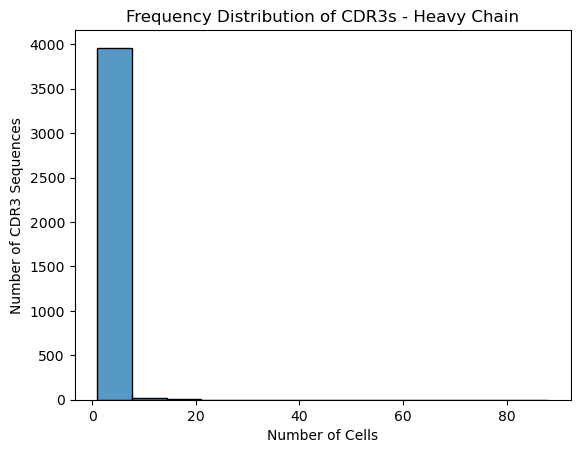

In [162]:
cdr3h_seq_counts = config_h.groupby('cdr3').count().sort_values('is_cell', ascending=False)[['is_cell']].reset_index()

sns.histplot(np.array(cdr3h_seq_counts['is_cell'])).set(
    title="Frequency Distribution of CDR3s - Heavy Chain", 
    xlabel="Number of Cells",
    ylabel="Number of CDR3 Sequences");

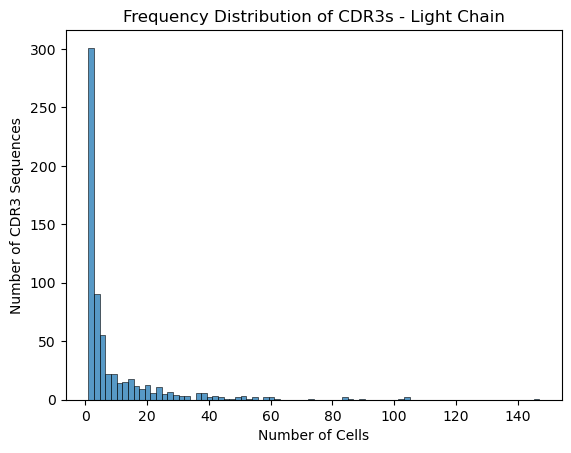

In [163]:
cdr3l_seq_counts = config_l.groupby('cdr3').count().sort_values('is_cell', ascending=False)[['is_cell']].reset_index()

sns.histplot(np.array(cdr3l_seq_counts['is_cell'])).set(
    title="Frequency Distribution of CDR3s - Light Chain", 
    xlabel="Number of Cells",
    ylabel="Number of CDR3 Sequences");

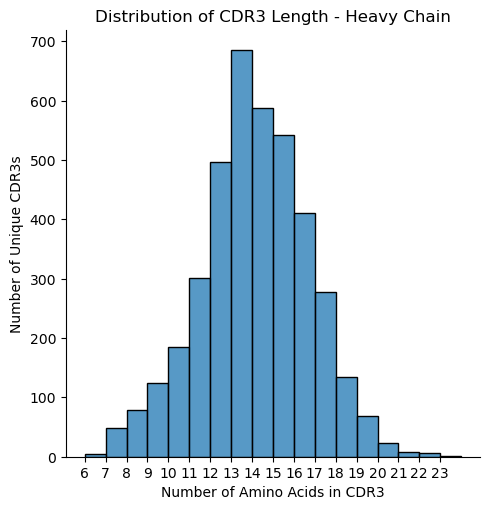

In [164]:
cdr3h_len = config_h['cdr3'].drop_duplicates().apply(len)
cdr3h_len_min = min(cdr3h_len)
cdr3h_len_max = max(cdr3h_len)

sns.displot(cdr3h_len, bins=cdr3h_len_max-cdr3h_len_min, binrange=(cdr3h_len_min, cdr3h_len_max)).set(
    title="Distribution of CDR3 Length - Heavy Chain", 
    xlabel="Number of Amino Acids in CDR3",
    ylabel="Number of Unique CDR3s")


plt.xticks(np.arange(cdr3h_len_min, cdr3h_len_max));

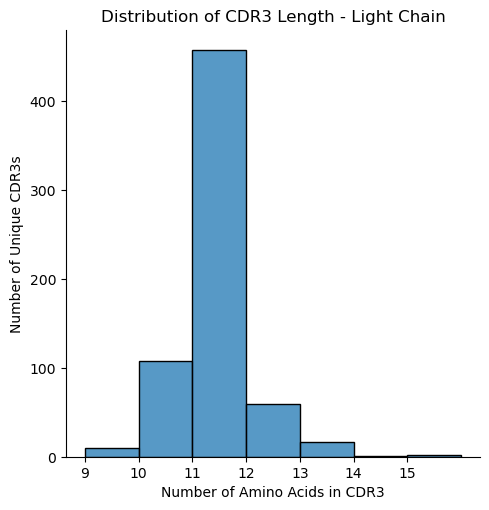

In [165]:
cdr3l_len = config_l['cdr3'].drop_duplicates().apply(len)
cdr3l_len_min = min(cdr3l_len)
cdr3l_len_max = max(cdr3l_len)

sns.displot(cdr3l_len, bins=cdr3l_len_max-cdr3l_len_min, binrange=(cdr3l_len_min, cdr3l_len_max)).set(
    title="Distribution of CDR3 Length - Light Chain", 
    xlabel="Number of Amino Acids in CDR3",
    ylabel="Number of Unique CDR3s")


plt.xticks(np.arange(cdr3l_len_min, cdr3l_len_max));

## Filter Configs

Decided to only use all cells with only Heavy CRD3, but can only have one or two contigs associated per barcode

In [8]:
# Select the cells that only have 2 productive sequences
#barcode_w_pair_list = barcode_counts[barcode_counts.is_cell == 2]['barcode'].tolist()
#filtered_config = config[config.barcode.isin(barcode_w_pair_list)]
#filtered_config

In [9]:
# Create a dataframe where one row corresponds to one cell with two sets of chain sequence
#heavy_chains = filtered_config[filtered_config['chain'] == "IGH"].set_index('barcode')[['cdr1', 'cdr2', 'cdr3']]
#heavy_chains = heavy_chains.rename(columns={"cdr1": "h_cdr1", "cdr2": "h_cdr2", "cdr3": "h_cdr3"})

#light_chains = filtered_config[filtered_config['chain'] != "IGH"].set_index('barcode')[['cdr1', 'cdr2', 'cdr3']]
#light_chains = light_chains.rename(columns={"cdr1": "l_cdr1", "cdr2": "l_cdr2", "cdr3": "l_cdr3"}) 

# Do an inner join to remove any chance of keeping cells with double heavy chain or double light chain
#chains = heavy_chains.merge(light_chains, left_index=True, right_index=True, how='inner').reset_index()
#chains

is_cell
sample_num barcode                    
pool_1     AAACCTGAGCTCTCGG-1        2
           AAACCTGAGTGCCATT-1        1
           AAACCTGCAAGCTGAG-1        1
           AAACCTGCACATTCGA-1        1
           AAACCTGCACTGAAGG-1        1
...                                ...
pool_2     TTTGTCACATGGTAGG-1        2
           TTTGTCATCACCCGAG-1        2
           TTTGTCATCACGATGT-1        1
           TTTGTCATCGCCAAAT-1        2
           TTTGTCATCTCAAACG-1        1

[9828 rows x 1 columns]

In [177]:
# Need to use both the sample_num and barcode to select the IGH since there are duplicate barcodes across multiple pools
barcode_cells_for_analysis = barcode_counts.set_index(['sample_num', 'barcode'])
barcode_cells_for_analysis = barcode_cells_for_analysis[barcode_cells_for_analysis['is_cell'] < 3]


chains = config.set_index(['sample_num', 'barcode']).loc[barcode_cells_for_analysis.index, :]
chains = chains[chains['chain'] == 'IGH'].reset_index()

chains = chains[['barcode', 'cdr3']].rename(columns={'cdr3': 'h_cdr3'})

chains

,barcode,h_cdr3
0,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW
1,AAACCTGCAGACACTT-1,CAWREPYYYGSRDDYW
2,AAACCTGCATCAGTAC-1,CAKEGYGNYESAMDYW
3,AAACCTGGTCTCCCTA-1,CARIRRTEYYAMDYW
4,AAACCTGGTGTTTGTG-1,CAIYYDYAWFAYW
...,...,...
5606,TTTGTCACAACTGCGC-1,CARSYYRYAFAYW
5607,TTTGTCACACTTACGA-1,CARPIYYYGSSPAWFAYW
5608,TTTGTCACATGGTAGG-1,CARESDGYYSWFAYW
5609,TTTGTCATCACCCGAG-1,CARDLYDYYFDYW


## Generate Distance Matricies

In [178]:
def distance_matrix(cdr):
    # Function that accepts a CDR column and ouputs a levenshtein distance matrix
    # Note: this process is computationally intensive
    
    # Prepare 2 dimensional array M x N (M entries (len cdr3_sequences) with N dimensions (1)) 
    transformed_strings = np.array(cdr).reshape(-1,1)
    
    # Calculate distance matrix using the Levenshtein distance function
    distance_matrix = pdist(transformed_strings, lambda x,y: lev.distance(x[0],y[0]))
    
    # Square distance matrix
    cdr_matrix = squareform(distance_matrix).astype(np.int64)
    
    return cdr_matrix

# Calculate all six distance matricies
#h_cdr1_mtx = distance_matrix(chains['h_cdr1'])
#h_cdr2_mtx = distance_matrix(chains['h_cdr2'])
h_cdr3_mtx = distance_matrix(chains['h_cdr3'])
#l_cdr1_mtx = distance_matrix(chains['l_cdr1'])
#l_cdr2_mtx = distance_matrix(chains['l_cdr2'])
#l_cdr3_mtx = distance_matrix(chains['l_cdr3'])

## Examine Possible Distance Weights

In [179]:
#meta_mtx = meta_distance_matrix()
meta_mtx = h_cdr3_mtx

In [180]:
# Identify the cutoff point on whether there should be an edge between two nodes 
# Based on https://www.frontiersin.org/articles/10.3389/fimmu.2018.00224/full#h3, 
# the standard is one amino acid difference
cutoff_point = 2

# Generate binary boolean distance matrix
boolean_filter = meta_mtx < cutoff_point
boolean_filter = boolean_filter.astype(int)

G = nx.Graph()

# Add the nodes per unique sequence
G.add_nodes_from(np.arange(meta_mtx.shape[0]))

# Add the edges
# Take the upper right triangular matrix w/out diagnonal
# https://people.revoledu.com/kardi/tutorial/VB/tips/Symmetric-Matrix.html
for row in np.arange(0, meta_mtx.shape[0]-1):
    for col in np.arange(row+1, meta_mtx.shape[0]):
        if boolean_filter[row, col] == 1:
            G.add_weighted_edges_from([(row, col, 1)])

# Set node weights based on number of edges
#node_degree = [G.degree(x) for x in np.arange(len(cdr3_sequences))]
#for i in np.arange(len(cdr3_sequences)):
#    G.nodes[i]['size'] = node_degree[i]

# Node degree - number of edges per node
# Calculate this before removing the nodes with no edges
#degree_sequence = [d for n, d in G.degree()]

# Remove nodes with no edges
#G.remove_nodes_from(list(nx.isolates(G)))

# To visualize graph (note: computationally intensive)
#gv.d3(G, edge_size_data_source='weight', use_node_size_normalization=True)

clusters = sorted(nx.connected_components(G), key=len, reverse=True)
top10_clusters = [list(x) for x in clusters[:10]]

In [181]:
#gv.d3(G, edge_size_data_source='weight', use_node_size_normalization=True)

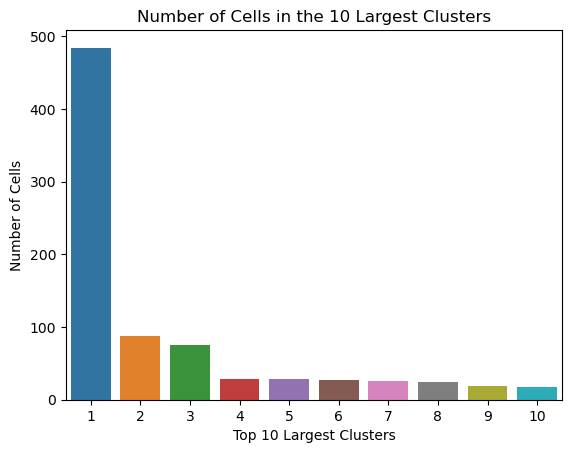

In [182]:
ax = sns.barplot(x=np.arange(1, 11), y=[len(x) for x in top10_clusters])

plt.xlabel("Top 10 Largest Clusters")
plt.ylabel("Number of Cells")
plt.title("Number of Cells in the 10 Largest Clusters");

In [253]:
cluster_cdr_len = pd.DataFrame()
cluster_cdr_len['Cell Number'] = list(nx.degree_centrality(G).keys())

# Add sequence data
cluster_cdr_len = pd.concat([cluster_cdr_len, chains.reset_index(drop=True)], axis=1)

# Label the cells in the top clusters
def find_cluster(cell_num):
    for i in range(len(top10_clusters)):
        if int(cell_num) in top10_clusters[i]:
            return i+1
    #return None

cluster_cdr_len['top_clusters'] = cluster_cdr_len["Cell Number"].apply(find_cluster)

# Select only the top 3 clusters
cluster_cdr_len_top3 = cluster_cdr_len[cluster_cdr_len['top_clusters'].isin([1, 2, 3])]

cluster_cdr_len_top3['length'] = cluster_cdr_len_top3['h_cdr3'].apply(len)

cluster_cdr_len_top3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Cell Number,barcode,h_cdr3,top_clusters,length
0,0,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW,2.0,15
8,8,AAACGGGCACGAAAGC-1,CARYYKYDYYAMDFW,2.0,15
13,13,AAAGATGGTAAATACG-1,CARYYKYDYYAMDFW,2.0,15
15,15,AAAGCAACAAAGGAAG-1,CTIFDYW,1.0,7
17,17,AAAGCAAGTAGTACCT-1,CARGEGYDYAMDYW,1.0,14
...,...,...,...,...,...
5575,5575,TTGTAGGTCGGTTAAC-1,CMRYGSSYWYFDVW,3.0,14
5588,5588,TTTCCTCAGTCCGGTC-1,CARYDGYYYFDYW,1.0,13
5589,5589,TTTCCTCGTCGCCATG-1,CARDYAYAMDYW,1.0,12
5598,5598,TTTGCGCAGGATCGCA-1,CAREREAMDYW,1.0,11


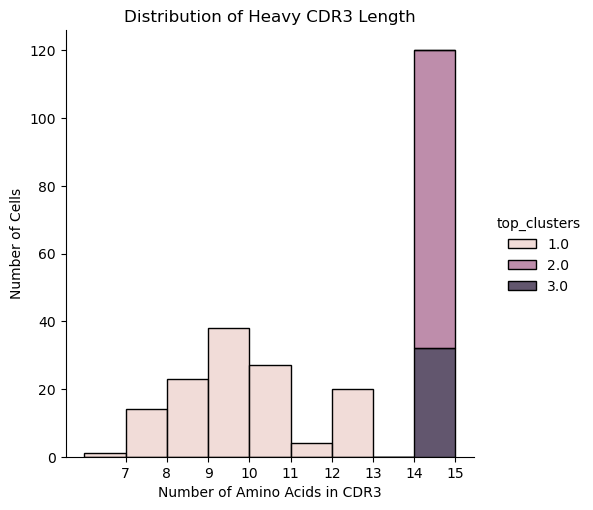

In [321]:
cluster_cdr_len_top3_min = min(cluster_cdr_len_top3['length'])
cluster_cdr_len_top3_max = max(cluster_cdr_len_top3['length'])

sns.displot(data=cluster_cdr_len_top3,
            x='length', 
            bins=cluster_cdr_len_top3_max-cluster_cdr_len_top3_min, 
            binrange=(cluster_cdr_len_top3_min, cluster_cdr_len_top3_max),
            hue='top_clusters', multiple = 'stack').set(
    title="Distribution of Heavy CDR3 Length", 
    xlabel="Number of Amino Acids in CDR3",
    ylabel="Number of Cells")


plt.xticks(np.arange(cluster_cdr_len_top3_min, cluster_cdr_len_top3_max)+1);

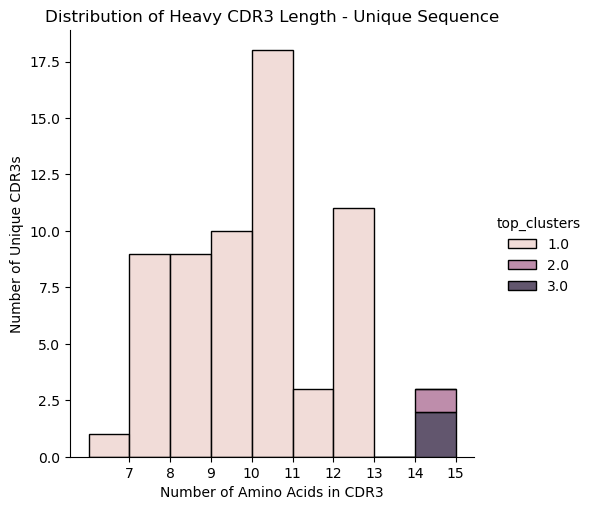

In [380]:
cluster_cdr_len_top3_min = min(cluster_cdr_len_top3['length'])
cluster_cdr_len_top3_max = max(cluster_cdr_len_top3['length'])

sns.displot(data=cluster_cdr_len_top3.drop_duplicates('h_cdr3'),
            x='length', 
            bins=cluster_cdr_len_top3_max-cluster_cdr_len_top3_min, 
            binrange=(cluster_cdr_len_top3_min, cluster_cdr_len_top3_max),
            hue='top_clusters', multiple = 'stack').set(
    title="Distribution of Heavy CDR3 Length - Unique Sequence", 
    xlabel="Number of Amino Acids in CDR3",
    ylabel="Number of Unique CDR3s")


plt.xticks(np.arange(cluster_cdr_len_top3_min, cluster_cdr_len_top3_max)+1);

In [381]:
degree_centrality = pd.DataFrame()
degree_centrality['Cell Number'] = list(nx.degree_centrality(G).keys())

# Use nx.degree_centrality(G) to get the number of edges per node
degree_centrality['degree_centrality_norm'] = list(nx.degree_centrality(G).values())
degree_centrality['degree_centrality_norm'] = np.round(degree_centrality['degree_centrality_norm']*chains.shape[0], 1)
degree_centrality = degree_centrality.rename(columns={"degree_centrality_norm": "Number of Edges"})

# Add sequence data
#degree_centrality = pd.concat([degree_centrality, chains.reset_index(drop=True)], axis=1)

# Label the cells in the top clusters
def find_cluster(cell_num):
    for i in range(len(top10_clusters)):
        if int(cell_num) in top10_clusters[i]:
            return i+1
    #return None

degree_centrality['top_clusters'] = degree_centrality["Cell Number"].apply(find_cluster)

degree_centrality

,Cell Number,Number of Edges,top_clusters
0,0,87.0,2.0
1,1,0.0,NaN
2,2,0.0,NaN
3,3,0.0,NaN
4,4,1.0,NaN
...,...,...,...
5606,5606,0.0,NaN
5607,5607,0.0,NaN
5608,5608,0.0,NaN
5609,5609,1.0,NaN


In [382]:
# For the cells in the top cluster, calculate degree centrality norm

top_clusters_df = pd.DataFrame()

for cluster_num in np.arange(1, 4):
    cluster = degree_centrality[degree_centrality['top_clusters'] == cluster_num]
    cluster['degree_centrality_norm'] = cluster['Number of Edges']/cluster.shape[0]
    top_clusters_df = pd.concat([top_clusters_df, cluster], axis=0)
    
    
    
# Filter out some of the lower cells with lower degree centrality norm
top_clusters_df_filtered_ids = pd.DataFrame()

for cluster_num in np.arange(1, 4):
    cluster = top_clusters_df[top_clusters_df['top_clusters'] == cluster_num]
        
    if len(np.unique(cluster['degree_centrality_norm'])) != 1:
        q75 = cluster['degree_centrality_norm'].quantile(q=0.75)
        cluster = cluster[cluster['degree_centrality_norm'] >= q75]
        cluster = cluster.sort_values('degree_centrality_norm', ascending=False) #.head(round(cluster.shape[0]/2))
        top_clusters_df_filtered_ids = pd.concat([top_clusters_df_filtered_ids, cluster], axis=0)
    
    else:
        top_clusters_df_filtered_ids = pd.concat([top_clusters_df_filtered_ids, cluster], axis=0)
        
top_clusters_df_filtered_ids

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Cell Number,Number of Edges,top_clusters,degree_centrality_norm
2304,2304,33.0,1.0,0.068182
3222,3222,33.0,1.0,0.068182
2227,2227,33.0,1.0,0.068182
777,777,33.0,1.0,0.068182
4993,4993,33.0,1.0,0.068182
...,...,...,...,...
1169,1169,31.0,3.0,0.413333
1155,1155,31.0,3.0,0.413333
1102,1102,31.0,3.0,0.413333
1000,1000,31.0,3.0,0.413333


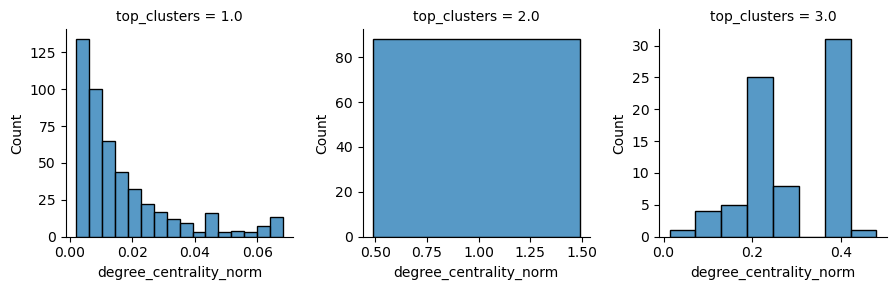

In [383]:
g = sns.FacetGrid(top_clusters_df, col = "top_clusters", col_wrap=5, sharey=False, sharex=False)
g.map(sns.histplot, 'degree_centrality_norm')

In [384]:
# Filter cells by NDC
cluster_cdr_len_top3 = cluster_cdr_len_top3[cluster_cdr_len_top3['Cell Number'].isin(top_clusters_df_filtered_ids['Cell Number'])]
cluster_cdr_len_top3

,Cell Number,barcode,h_cdr3,top_clusters,length
0,0,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW,2.0,15
8,8,AAACGGGCACGAAAGC-1,CARYYKYDYYAMDFW,2.0,15
13,13,AAAGATGGTAAATACG-1,CARYYKYDYYAMDFW,2.0,15
35,35,AAATGCCTCTACTATC-1,CARGPFAYW,1.0,9
80,80,AACTCTTCATACGCCG-1,CARYYKYDYYAMDFW,2.0,15
...,...,...,...,...,...
5334,5334,TGACGGCCACGAAATA-1,CARGDYFDYW,1.0,10
5345,5345,TGACTTTGTGCAACTT-1,CARIGAMDYW,1.0,10
5411,5411,TGCTACCGTAGAAAGG-1,CARDGYYAMDYW,1.0,12
5477,5477,TGTGTTTTCGTCCGTT-1,CMRYDGYYWYFDVW,3.0,14


## Consensus Analysis

In [385]:
def cluster_consensus_sequence(cluster_df, most_common_aa_cutoff = 75, double_aa_cutoff = 80, num_possible_aa = 3):
    # Input:
    ## Cluster sequence dataframe
    ## Most common aa cutoff - If an amino acid at a position is x% or higher, it will always be that amino acid at that position
    ## Number of possible amino acids - selects the n number of possible amino acids per position, in highest to lowest frequency
    
    # Output:
    ## Consensus sequences per CDR region
    ## Percent frequency of each amino acid per position, useful for visualization purposes
    
    cluster_consensus_sequence_results = {}
    percentage_position_matrix_list = {}
    
    aa_options = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U'] #'-', 
    
    cdr_column_names = cluster_df.columns[cluster_df.columns.str.contains("cdr")].to_list()
    
    for cdr_column_name in cdr_column_names:

       # Conduct MSA of all the sequences within the cluster
        seq_to_align = [seq.ProteinSequence(cdr_sequence) for cdr_sequence in cluster_df[cdr_column_name]]
        biotite_sub_matrix = seq.align.SubstitutionMatrix.std_protein_matrix()
        alignment, order, tree, distances = seq.align.align_multiple(seq_to_align, biotite_sub_matrix, gap_penalty=-1000)
            
        # Extract the aligned sequences post-MSA, convert None to "-"
        #print(alignment)
        alignment_mtx = np.array(seq.align.get_symbols(alignment))
        alignment_mtx[alignment_mtx == None] = "-"
            
        # Create a percentage position matrix where for each amino acid position, there is a percentage frequency for all amino acids
        raw_data = {}

        for aa in aa_options:
            raw_data[aa] = list(np.sum(alignment_mtx == aa, axis=0)/alignment_mtx.shape[0]*100)
                
        # Save results for visualizing percentage position if desired
        percentage_position_matrix_list[cdr_column_name] = raw_data
                
            
        ## Generate the consensus sequences based on percent_cutoff and num_possible_aa
        percent_position_matrix = pd.DataFrame(raw_data, columns=raw_data.keys())
            
        # Create a list where every sublist is one position and has num_possible_aa number of amino acids at that position for consensus generation
        # So [[A], [B, C], [D]] -> (A, B, D) and (A, C, D)
        common_aa_per_position = []
            
        for position_idx in np.arange(percent_position_matrix.shape[0]):
                
            position = percent_position_matrix.iloc[position_idx]
                
            # If a amino acid occurs most_common_aa_cutoff% at a position, it is always that amino acid
            if len(position[position >= most_common_aa_cutoff]) == 1:
                common_aa = position[position >= most_common_aa_cutoff].index.to_list()
                
            # If the top 2 amino acids add up to make up double_aa_cutoff%, just select those two 
            elif position.sort_values(ascending=False).head(2).sum() >= double_aa_cutoff:
                common_aa = position.sort_values(ascending=False).head(2).index.to_list()
                    
                # If the position is more diverse, select the top num_possible_aa
            else:
                common_aa = position.sort_values(ascending=False)[:num_possible_aa].index.to_list()
    
            common_aa_per_position += [common_aa]
    
        # Generate all the possible consensus sequence combinations 
        cdr_consensus_sequence_possible_combinations = [list(x) for x in itertools.product(*common_aa_per_position)]
        
        # Collapse the list into a string
        cluster_consensus_sequence_results = []
        for consensus_sequence in cdr_consensus_sequence_possible_combinations:
            cluster_consensus_sequence_results += ["".join([aa for aa in consensus_sequence if aa != "-"])]
        
        # Remove any duplicates as a result of the sequence combination generation process from the extra space as a possible combo
        cluster_consensus_sequence_results = [*set(cluster_consensus_sequence_results)]
        
    return cluster_consensus_sequence_results, percentage_position_matrix_list

In [386]:
# Generate consensus sequences for each cluster

consensus_df = pd.DataFrame()

for cluster_num in np.arange(1, 4):
    cluster = cluster_cdr_len_top3[cluster_cdr_len_top3['top_clusters'] == cluster_num]
    
    for seq_len in np.arange(min(cluster['length']), max(cluster['length'])+1,):
        cluster_specific_length = cluster[cluster['length'] == seq_len].drop_duplicates('h_cdr3')
    
        cluster_consensus, cluster_pp = cluster_consensus_sequence(cluster_specific_length)
        
        # Create dataframe to append to
        cluster_consensus_df = pd.DataFrame(cluster_consensus, columns=['cluster_consensus'])
        cluster_consensus_df['cluster'] = cluster_num
        cluster_consensus_df['length'] = seq_len
        
        #consensus_df += [[cluster_num, seq_len, cluster_consensus]]
    
        #cluster_df = pd.DataFrame([cluster, seq_len, cluster_consensus], columns=['cluster', 'length', 'consensus_sequence'])
    
    # Create sequence num col
    #cluster_df = cluster_df.reset_index().rename(columns={"index": "consensus_num"})
    #cluster_df['consensus_num'] = cluster_df['consensus_num']+1
    
    #cluster_df['cluster'] = cluster_num
    
        consensus_df = pd.concat([consensus_df, cluster_consensus_df], axis=0)
        
consensus_df = consensus_df.reset_index().rename(columns={"index": "consensus_num"})
consensus_df['consensus_num'] = consensus_df['consensus_num']+1
    
# Sequence id col
consensus_df['consensus_id'] = "Cluster " + consensus_df['cluster'].astype(str) + ", Length " +  consensus_df['length'].astype(str) + ", Sequence " + consensus_df['consensus_num'].astype(str)

#consensus_df = consensus_df[['cluster', 'consensus_id', 'consensus_sequence']]

#consensus_df = pd.DataFrame(consensus_df, columns=['cluster', 'length', 'consensus_sequence'])

consensus_df

,consensus_num,cluster_consensus,cluster,length,consensus_id
0,1,CARAYW,1,6,"Cluster 1, Length 6, Sequence 1"
1,1,CARDDYW,1,7,"Cluster 1, Length 7, Sequence 1"
2,2,CARRDYW,1,7,"Cluster 1, Length 7, Sequence 2"
3,3,CARLAYW,1,7,"Cluster 1, Length 7, Sequence 3"
4,4,CARDAYW,1,7,"Cluster 1, Length 7, Sequence 4"
...,...,...,...,...,...
219,143,CARDDYYYFDYW,1,12,"Cluster 1, Length 12, Sequence 143"
220,144,CARGGGNYMDYW,1,12,"Cluster 1, Length 12, Sequence 144"
221,1,CARYYKYDYYAMDFW,2,15,"Cluster 2, Length 15, Sequence 1"
222,1,CMRYDGNYWYFDVW,3,14,"Cluster 3, Length 14, Sequence 1"


In [387]:
consensus_df.groupby('cluster').count()[['cluster_consensus']].rename(columns={'cluster_consensus': 'Number of Consensus Seq'})

,Number of Consensus Seq
cluster,
1,221
2,1
3,2


In [388]:
consensus_df.groupby(['cluster', 'length']).count()[['cluster_consensus']].rename(columns={'cluster_consensus': 'Number of Consensus Seq'})

Number of Consensus Seq
cluster length                         
1       6                             1
        7                             6
        8                             6
        9                            24
        10                           36
        11                            4
        12                          144
2       15                            1
3       14                            2

In [389]:
def visualize_position_frequency_matrix_cdr3(percentage_position_matrix_list, title):
    
    percent_position_matrix = pd.DataFrame(percentage_position_matrix_list['h_cdr3'])
    print(percent_position_matrix.shape)
    
    # Get the most common amino acid in each position
    aligned_sequence_most_frequent_char = percent_position_matrix.idxmax(axis="columns")
    
    # Visualize the stacked percentage bar plot

    barWidth = 0.85
    aa_position = np.arange(percent_position_matrix.shape[0])

    cm = plt.get_cmap('gist_rainbow')

    for col_idx in np.arange(percent_position_matrix.shape[1]):

        # Generate unique color based on number of amino acids
        color = cm(1.*col_idx/percent_position_matrix.shape[1])

        # Plot the "-" 
        if col_idx == 0 and percent_position_matrix.columns[col_idx] == "-":
            plt.bar(aa_position, percent_position_matrix.iloc[:, col_idx], 
                    color="white", edgecolor='lightgray', width=barWidth, 
                    label=percent_position_matrix.columns[col_idx])

        # Plot the 20 other amino acids
        else:
            plt.bar(aa_position, percent_position_matrix.iloc[:, col_idx], 
                    bottom=np.sum(percent_position_matrix.iloc[:, :col_idx], axis=1),
                    color=color, edgecolor='lightgray', width=barWidth, 
                    label=percent_position_matrix.columns[col_idx])

    # Custom x axis
    #plt.xticks(aa_position, aligned_sequence_most_frequent_char)
    plt.xticks(aa_position, np.arange(1, percent_position_matrix.shape[0]+1))
    plt.xlabel("CDR3 Position")

    plt.ylabel("Percentage")

    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2, title="Amino Acid")

    plt.title(title)

    plt.show()

(12, 21)


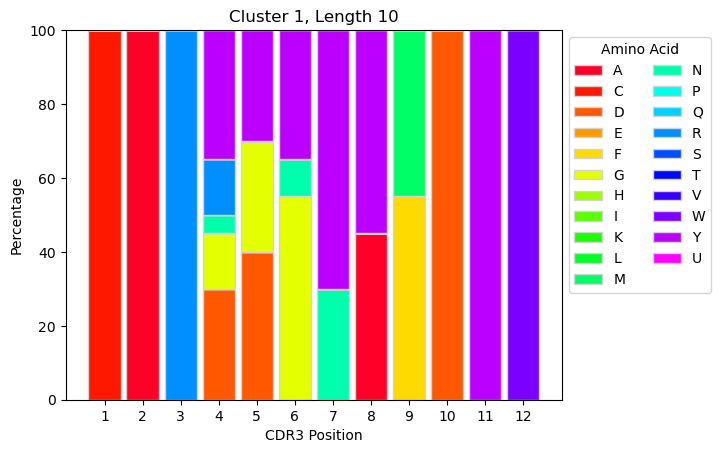

In [390]:
visualize_position_frequency_matrix_cdr3(cluster_pp12, "Cluster 1, Length 10")

## Compare Generated Consensus Sequences with Established Sequences

In [391]:
established_sequences = pd.read_excel("data/110622_23_ILT2_ILT4_sequences_deom_37_clones_for_expression.xlsx")
established_sequences = established_sequences[['index', 'H-CDR3_aa']].drop_duplicates('H-CDR3_aa')
established_sequences

,index,H-CDR3_aa
0,mAb18,VAYNDYVLFAY
2,mAb20,AYFYYGSSYTMDY
5,mAb23,SNYRYDDYAMDY
6,mAb24,TSNFDY
7,mAb25,GGHGITTIVSFDL
10,mAb28,TNYRYDDYAMDF
11,mAb29,SRAMDY
12,mAb30,SIGTGFAY
13,mAb31,NGYYGRYYALDY
14,mAb32,ADFYDYFAMDS


In [398]:
cluster_cdr_len_top3

,Cell Number,barcode,h_cdr3,top_clusters,length
0,0,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW,2.0,15
8,8,AAACGGGCACGAAAGC-1,CARYYKYDYYAMDFW,2.0,15
13,13,AAAGATGGTAAATACG-1,CARYYKYDYYAMDFW,2.0,15
35,35,AAATGCCTCTACTATC-1,CARGPFAYW,1.0,9
80,80,AACTCTTCATACGCCG-1,CARYYKYDYYAMDFW,2.0,15
...,...,...,...,...,...
5334,5334,TGACGGCCACGAAATA-1,CARGDYFDYW,1.0,10
5345,5345,TGACTTTGTGCAACTT-1,CARIGAMDYW,1.0,10
5411,5411,TGCTACCGTAGAAAGG-1,CARDGYYAMDYW,1.0,12
5477,5477,TGTGTTTTCGTCCGTT-1,CMRYDGYYWYFDVW,3.0,14


In [414]:
top_consensus_across_cluster_and_lengths = []

for cluster_num in np.arange(1, 4):
    cluster = cluster_cdr_len_top3[cluster_cdr_len_top3['top_clusters'] == cluster_num]
    
    for seq_length in range(min(cluster['length']), max(cluster['length'])+1):
        cluster_length_specific = cluster[cluster['length'] == seq_length]
        
        #print(cluster_num, seq_length)
        
        cluster_consensus, cluster_pp = cluster_consensus_sequence(cluster_length_specific, most_common_aa_cutoff = 75, double_aa_cutoff = 100, num_possible_aa = 1)
        
        top_consensus_across_cluster_and_lengths += [[cluster_num, seq_length, cluster_consensus[0]]]
        
        #print(top_consensus_across_cluster_and_lengths)
        
top_consensus_across_cluster_and_lengths = pd.DataFrame(top_consensus_across_cluster_and_lengths, columns=['cluster', 'length', 'cluster_consensus'])

# Sequence id col
top_consensus_across_cluster_and_lengths['consensus_id'] = "Cluster " + top_consensus_across_cluster_and_lengths['cluster'].astype(str) + ", Length " +  top_consensus_across_cluster_and_lengths['length'].astype(str) 

top_consensus_across_cluster_and_lengths

,cluster,length,cluster_consensus,consensus_id
0,1,6,CARAYW,"Cluster 1, Length 6"
1,1,7,CARWDYW,"Cluster 1, Length 7"
2,1,8,CARNWDYW,"Cluster 1, Length 8"
3,1,9,CARGAMDYW,"Cluster 1, Length 9"
4,1,10,CARGGAMDYW,"Cluster 1, Length 10"
5,1,11,CARDYYAMDYW,"Cluster 1, Length 11"
6,1,12,CARYDGYAMDYW,"Cluster 1, Length 12"
7,2,15,CARYYKYDYYAMDFW,"Cluster 2, Length 15"
8,3,14,CMRYDGYYWYFDVW,"Cluster 3, Length 14"


In [415]:
concat_consensus = top_consensus_across_cluster_and_lengths[['consensus_id', 'cluster', 'length', 'cluster_consensus']].rename(columns={'consensus_id': 'index', 'cluster_consensus': 'h_cdr3'})

# Strip the C and W at the beginning and the end
concat_consensus['h_cdr3'] = concat_consensus['h_cdr3'].apply(lambda x: x[1:-1])

concat_established = established_sequences[['index', 'H-CDR3_aa']].rename(columns={'H-CDR3_aa': 'h_cdr3'})

consensus_established_seq = pd.concat([concat_consensus, concat_established]).reset_index(drop=True)

consensus_established_seq

,index,cluster,length,h_cdr3
0,"Cluster 1, Length 6",1.0,6.0,ARAY
1,"Cluster 1, Length 7",1.0,7.0,ARWDY
2,"Cluster 1, Length 8",1.0,8.0,ARNWDY
3,"Cluster 1, Length 9",1.0,9.0,ARGAMDY
4,"Cluster 1, Length 10",1.0,10.0,ARGGAMDY
5,"Cluster 1, Length 11",1.0,11.0,ARDYYAMDY
6,"Cluster 1, Length 12",1.0,12.0,ARYDGYAMDY
7,"Cluster 2, Length 15",2.0,15.0,ARYYKYDYYAMDF
8,"Cluster 3, Length 14",3.0,14.0,MRYDGYYWYFDV
9,mAb18,NaN,NaN,VAYNDYVLFAY


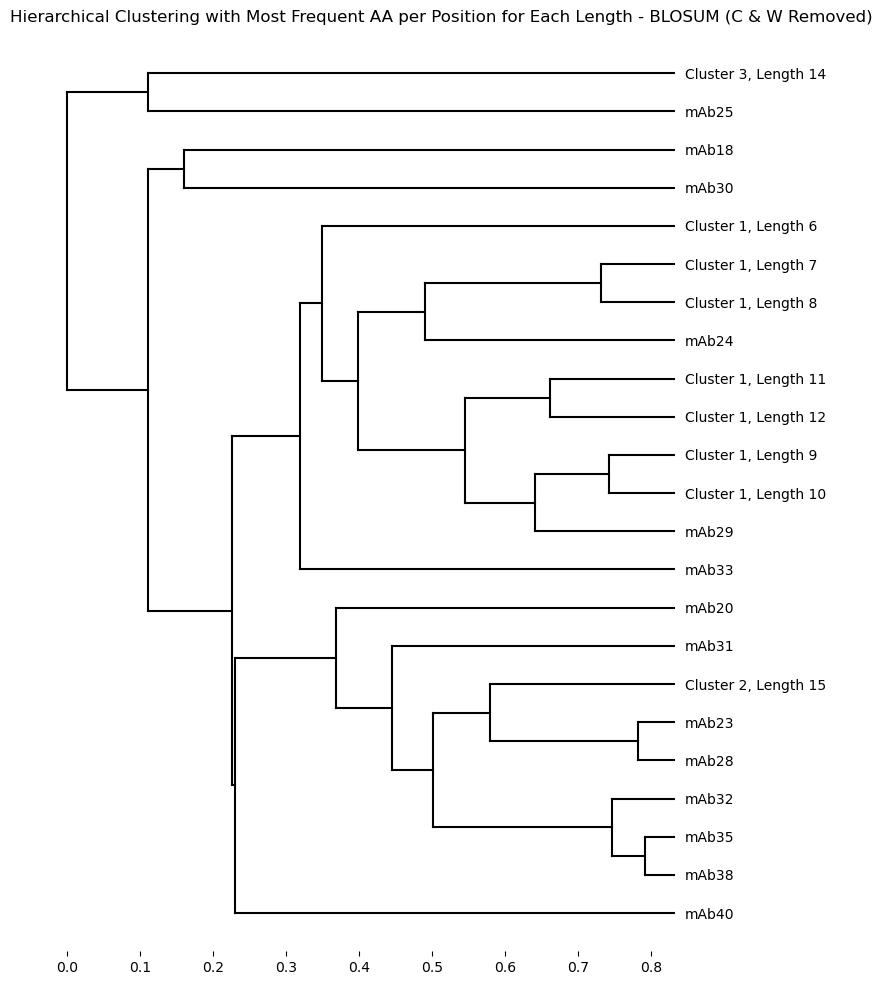

In [419]:
alignment, order, tree, distances = seq.align.align_multiple(
    [seq.ProteinSequence(x) for x in consensus_established_seq['h_cdr3'].to_list()], blosum_matrix, gap_penalty=-5)

tree = seq.phylo.upgma(distances)

fig = plt.figure(figsize=(8.0, 10.0))
ax = fig.add_subplot(111)

graphics.plot_dendrogram(
    ax, tree, orientation="left", labels=consensus_established_seq['index'].to_list()
)

plt.suptitle('Hierarchical Clustering with Most Frequent AA per Position for Each Length - BLOSUM (C & W Removed)')
fig.tight_layout()

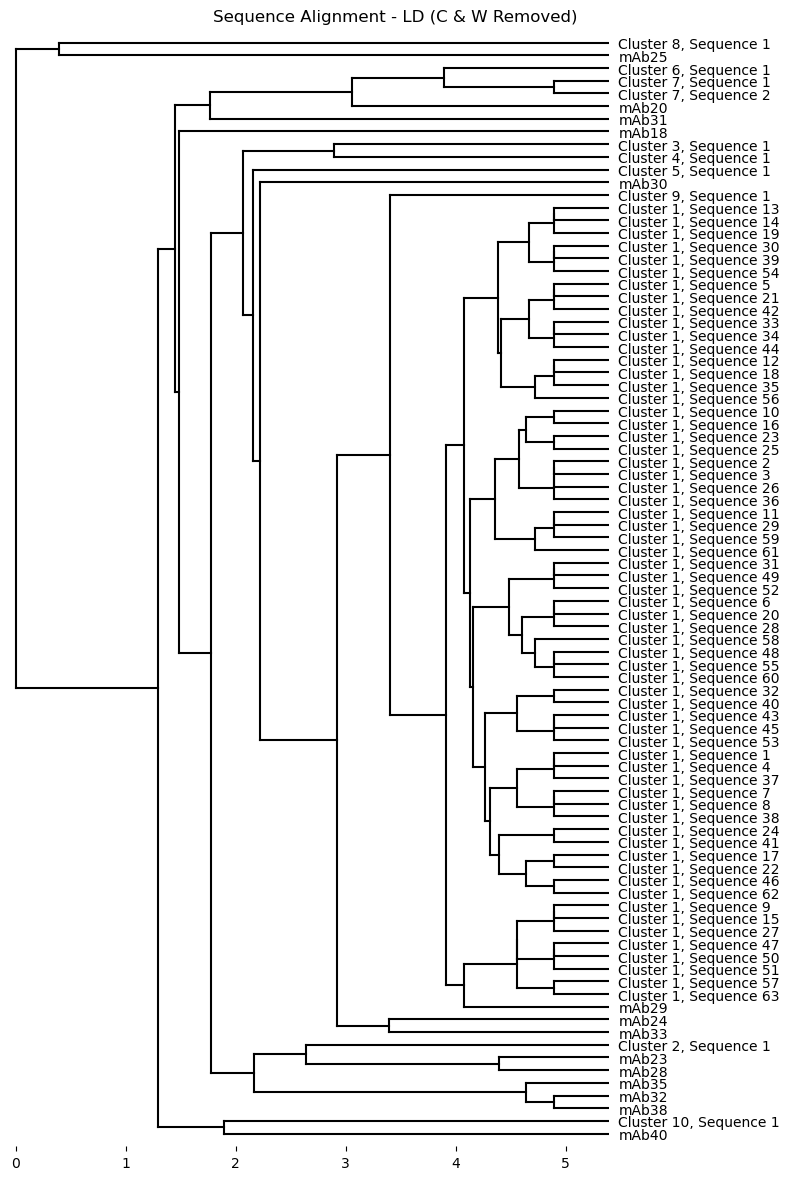

In [153]:
consensus_establish_dist_ld = distance_matrix(consensus_established_seq['h_cdr3'])

tree_ld = seq.phylo.upgma(consensus_establish_dist_ld)

fig = plt.figure(figsize=(8.0, 12.0))
ax = fig.add_subplot(111)

graphics.plot_dendrogram(
    ax, tree_ld, orientation="left", labels=consensus_established_seq['index'].to_list()
)

plt.suptitle('Sequence Alignment - LD (C & W Removed)')
fig.tight_layout()

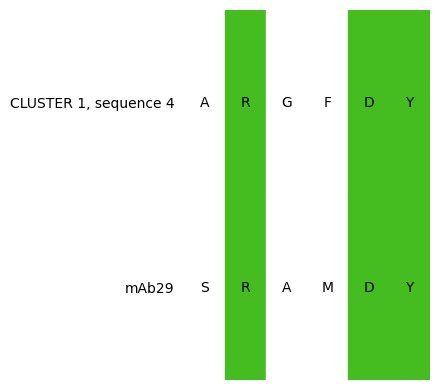

In [227]:
# Compare cluster to nearest hybridoma sequence

# Cluster 1
cluster_hybridoma_pair = ['CLUSTER 1, sequence 4', 'mAb29']
cluster_hybridoma = consensus_established_seq[consensus_established_seq['index'].isin(cluster_hybridoma_pair)]['h_cdr3']
alignment, order, tree, distances = seq.align.align_multiple([seq.ProteinSequence(x) for x in cluster_hybridoma], blosum_matrix)

fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=len(alignment),
    labels=cluster_hybridoma_pair
)
fig.tight_layout()

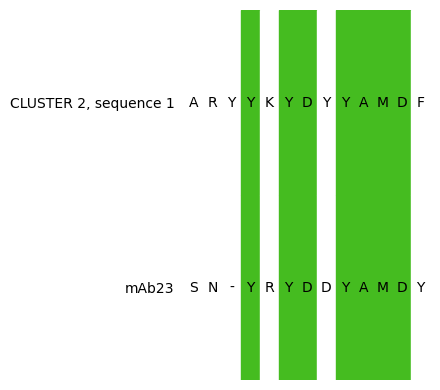

In [228]:
# Cluster 2
cluster_hybridoma_pair = ['CLUSTER 2, sequence 1', 'mAb23']
cluster_hybridoma = consensus_established_seq[consensus_established_seq['index'].isin(cluster_hybridoma_pair)]['h_cdr3']
alignment, order, tree, distances = seq.align.align_multiple([seq.ProteinSequence(x) for x in cluster_hybridoma], blosum_matrix)

fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=len(alignment),
    labels=cluster_hybridoma_pair
)
fig.tight_layout()

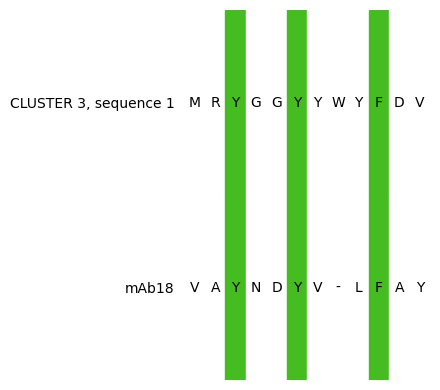

In [230]:
# Cluster 3
cluster_hybridoma_pair = ['CLUSTER 3, sequence 1', 'mAb18']
cluster_hybridoma = consensus_established_seq[consensus_established_seq['index'].isin(cluster_hybridoma_pair)]['h_cdr3']
alignment, order, tree, distances = seq.align.align_multiple([seq.ProteinSequence(x) for x in cluster_hybridoma], blosum_matrix)

fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=len(alignment),
    labels=cluster_hybridoma_pair
)
fig.tight_layout()

## Identify Sequence Similar to Hybridoma

Determine whether the 10X sequences have exact or extremely close matches to the hybridoma sequences

In [158]:
# Create all the possible combinations between the hybidoma and 10X sequences and calculate the LD 

# Remove the C and W before calculation
chains_hcdr3_no_cw = chains['h_cdr3'].apply(lambda x: x[1:-1])

hybridoma_vs_chain_ld = pd.DataFrame([list(x) for x in itertools.product(*[established_sequences['H-CDR3_aa'], chains_hcdr3_no_cw])], columns=['hybridoma_seq', 'bcr_seq'])
hybridoma_vs_chain_ld['LD'] = hybridoma_vs_chain_ld.apply(lambda x: lev.distance(x.hybridoma_seq, x.bcr_seq), axis=1)
hybridoma_vs_chain_ld

,hybridoma_seq,bcr_seq,LD
0,VAYNDYVLFAY,ARYYKYDYYAMDF,10
1,VAYNDYVLFAY,AWREPYYYGSRDDY,12
2,VAYNDYVLFAY,AKEGYGNYESAMDY,11
3,VAYNDYVLFAY,ARIRRTEYYAMDY,11
4,VAYNDYVLFAY,AIYYDYAWFAY,5
...,...,...,...
80117,LDTTAPYSMDY,ARSYYRYAFAY,9
80118,LDTTAPYSMDY,ARPIYYYGSSPAWFAY,13
80119,LDTTAPYSMDY,ARESDGYYSWFAY,10
80120,LDTTAPYSMDY,ARDLYDYYFDY,8


In [159]:
# Identify the closely related sequences within the 10X dataset compared to the hybridoma sequences
top_matches_per_hybridoma = pd.DataFrame()

for hybridoma in established_sequences['H-CDR3_aa']:
    # Take the top 5 matches
    top_hits = hybridoma_vs_chain_ld[hybridoma_vs_chain_ld['hybridoma_seq'] == hybridoma].sort_values('LD', ascending=True).head(5)
    
    top_matches_per_hybridoma = pd.concat([top_matches_per_hybridoma, top_hits], axis=0)

# Add the mAb index
top_matches_per_hybridoma = established_sequences.rename(columns={"H-CDR3_aa": "hybridoma_seq"}).set_index('hybridoma_seq').join(top_matches_per_hybridoma.set_index('hybridoma_seq'))

# Reformat the df
top_matches_per_hybridoma = top_matches_per_hybridoma.reset_index()

# Add the cluster info
def cluster_annotation(cell_number):
    for idx in range(len(top10_clusters)):
        if cell_number in top10_clusters[idx]:
            return idx+1
    return None
        
## Add the cell number of the sequence to get the cluster info
cell_number = pd.DataFrame(chains_hcdr3_no_cw).reset_index().set_index('h_cdr3')
cell_number = cell_number.rename(columns={'index': 'cell_number'})
top_matches_per_hybridoma = top_matches_per_hybridoma.set_index("bcr_seq").join(cell_number)

## Annotate with top 10 cluster info
top_matches_per_hybridoma['top_cluster'] = top_matches_per_hybridoma['cell_number'].apply(cluster_annotation)
top_matches_per_hybridoma = top_matches_per_hybridoma.reset_index().rename(columns={"level_0": "bcr_seq"})

top_matches_per_hybridoma = top_matches_per_hybridoma[['index', 'hybridoma_seq', 'bcr_seq', 'cell_number', 'LD', 'top_cluster']]
top_matches_per_hybridoma = top_matches_per_hybridoma.sort_values("LD", ascending=True)

top_matches_per_hybridoma

,index,hybridoma_seq,bcr_seq,cell_number,LD,top_cluster
151,mAb29,SRAMDY,VRAMDY,9245,1,NaN
149,mAb24,TSNFDY,TSFDY,16750,1,NaN
133,mAb33,GEDY,TGYDY,7793,2,NaN
132,mAb33,GEDY,TGYDY,7490,2,NaN
131,mAb33,GEDY,TGYDY,7474,2,NaN
...,...,...,...,...,...,...
29,mAb25,GGHGITTIVSFDL,ARGITTVFDY,13148,6,NaN
30,mAb25,GGHGITTIVSFDL,ARGITTVFDY,4592,6,NaN
31,mAb25,GGHGITTIVSFDL,ARGITTVFDY,13148,6,NaN
43,mAb25,GGHGITTIVSFDL,ARQGITTVVYFDY,12411,6,NaN


In [47]:
top_matches_per_hybridoma.to_excel("code/10X_bcr_vdj_example/ILT4/set1_10062022/set1_10062022_ILT4_hybridoma_matches.xlsx", index=None)

In [160]:
# Filter out the ones with low LD
top_matches_per_hybridoma_filtered = top_matches_per_hybridoma[top_matches_per_hybridoma['LD'] < 3].sort_values("LD")
top_matches_per_hybridoma_filtered

,index,hybridoma_seq,bcr_seq,cell_number,LD,top_cluster
151,mAb29,SRAMDY,VRAMDY,9245,1,NaN
149,mAb24,TSNFDY,TSFDY,16750,1,NaN
25,mAb29,SRAMDY,ARGAMDY,9870,2,NaN
147,mAb24,TSNFDY,TRGFDY,15554,2,NaN
5,mAb29,SRAMDY,ARDMDY,1226,2,NaN
26,mAb29,SRAMDY,ARGAMDY,15025,2,NaN
6,mAb29,SRAMDY,ARDMDY,7857,2,NaN
142,mAb24,TSNFDY,TIFDY,323,2,NaN
141,mAb24,TSNFDY,TIFDY,52,2,NaN
139,mAb33,GEDY,TGYDY,14919,2,NaN


In [161]:
top_matches_per_hybridoma.groupby("LD").count()

,index,hybridoma_seq,bcr_seq,cell_number,top_cluster
LD,,,,,
1,2,2,2,2,0
2,49,49,49,49,0
3,44,44,44,44,0
4,34,34,34,34,1
5,16,16,16,16,0
6,7,7,7,7,0


In [162]:
top_matches_per_hybridoma.groupby('index').mean().sort_values("LD")[["LD"]].rename(columns={"LD": "Average LD per Top 5 Hits"})

,Average LD per Top 5 Hits
index,
mAb24,1.833333
mAb29,1.950000
mAb33,2.000000
mAb30,2.500000
mAb23,3.000000
mAb35,3.000000
mAb38,3.000000
mAb20,3.285714
mAb28,4.000000
